# Notebook OCI in LABS - MLOps
## Notebook - Utilizando as bibliotecas: ADS, AutoML = Da construção do modelo até utilizando-o em Produção
### Para executar os comandos contidos em cada célula, é necessário colocar o cursor na célula e pressionar no teclado "Ctrl + Enter"

#### Vamos ajustar a versão da biblioteca ADS

In [ ]:
!pip install oracle-ads==2.5.9
!pip install -U oci

#### Agora é hora de carregar na memória a maioria das bibliotecas e funções que serão utilizadas neste script

In [1]:
def algo_selec(model):
    trials = model.model_selection_trials_
    fig, ax = plt.subplots(1)
    colors = []
    scores = [x[3] for x in trials]
    models = [x[0] for x in trials]
    y_margin = 0.10 * (max(scores) - min(scores))
    s = pd.Series(scores, index=models).sort_values(ascending=False)
    ax.set_title("Algorithm Selection Trials")
    for f in s.keys():
        if f == '{}_AS'.format(est_pred.selected_model_):
            colors.append('orange')
        elif s[f] >= s.mean():
            colors.append('teal')
        else:
            colors.append('turquoise')
    ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
    s.plot.bar(ax=ax, color=colors, edgecolor='black')
    ax.axhline(y=s.mean(), color='black', linewidth=0.5)
    return(plt.show())

def adap_sample(model):
    trials = model.adaptive_sampling_trials_
    fig, ax = plt.subplots(1)
    ax.set_title("Adaptive Sampling ({})".format(trials[0][0]))
    ax.set_xlabel('Dataset sample size')
    ax.set_ylabel(r"Predicted model score")
    scores = [x[3] for x in trials]
    n_samples = [x[1] for x in trials]
    y_margin = 0.10 * (max(scores) - min(scores))
    ax.grid(color='g', linestyle='-', linewidth=0.1)
    ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
    ax.plot(n_samples, scores, 'k:', marker="s", color='teal', markersize=3)
    return(plt.show())

def feat_selec(model):
    trials = model.feature_selection_trials_
    fig, ax = plt.subplots(1)
    ax.set_title("Feature Selection Trials")
    ax.set_xlabel("Number of Features")
    ax.set_ylabel(r"Predicted model score")
    scores = [x[3] for x in trials]
    n_features = [x[2] for x in trials]
    y_margin = 0.10 * (max(scores) - min(scores))
    ax.grid(color='g', linestyle='-', linewidth=0.1)
    ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
    ax.plot(n_features, scores, 'k:', marker="s", color='teal', markersize=3)
    ax.axvline(x=len(model.selected_features_names_), color='orange', linewidth=2.0)
    return(plt.show())

def hyper_tuning(model):
    trials = model.tuning_trials_
    fig, ax = plt.subplots(1)
    ax.set_title("Hyperparameter Tuning Trials")
    ax.set_xlabel("Iteration $n$")
    ax.set_ylabel(r"Computer model score")
    scores = [x[3] for x in reversed(trials)]
    y_margin = 0.10 * (max(scores) - min(scores))
    ax.grid(color='g', linestyle='-', linewidth=0.1)
    ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
    ax.plot(range(1, len(trials) + 1), scores, 'k:', marker="s", color='teal', markersize=3)
    return(plt.show())

In [20]:
%matplotlib inline

import io
import tempfile
import uuid
import ads
import mlx
import oci
import logging
import warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os

import seaborn as sn
import automl
plt.style.use('ggplot')

from os import path
from ads.common import auth as authutil
from ads.dataset.factory import DatasetFactory
from ads import set_documentation_mode
from ads import set_auth
from ads.dataflow.dataflow import DataFlow
from ads.common.model import ADSModel
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.common.data import ADSData
from ads.evaluations.evaluator import ADSEvaluator
from ads.catalog.model import ModelCatalog
from ads.common.model import ADSModel
from ads.model.deployment import ModelDeployer, ModelDeploymentProperties
from ads.common.model_export_util import prepare_generic_model
from ads.evaluations.evaluator import ADSEvaluator
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from automl import Pipeline, init
from ads.model.deployment import ModelDeployer, ModelDeploymentProperties
from ads.common.model_export_util import prepare_generic_model
from oci.data_science import DataScienceClient, DataScienceClientCompositeOperations
from oci.auth.signers import get_resource_principals_signer
from oci.data_science.models import ModelConfigurationDetails, InstanceConfiguration, \
                                    FixedSizeScalingPolicy, CategoryLogDetails, LogDetails, \
                                    SingleModelDeploymentConfigurationDetails, CreateModelDeploymentDetails
from ads.database import connection 
from ads.database.connection import Connector
from ads.dataset.factory import DatasetFactory
from ads.vault.vault import Vault
from ads.common.oci_logging import OCILogGroup
from ads.common.auth import default_signer
from mlx import PermutationImportance
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sqlalchemy import create_engine
from urllib.request import urlopen

ads.set_auth(auth="resource_principal")
set_documentation_mode(False)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings('ignore')
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

#### É possível acessar o conjunto de dados diretamente do Git

In [ ]:
df_CHD = pd.read_csv("https://raw.githubusercontent.com/rafaelrdias/OCI_In_Lab_MLOPS/main/framingham.csv")

#### Utilizaremos o conjunto de dados descrito anteriormente que está no bucket "rafa_lab" - Para que possam replicar copiar o nome do bucket e colar no lugar dos XXXXXXX entre aspas para o "bucket_name"

#### **** Importante: Será necessário trocar o nome do "namespace" contido entre aspas, para tanto:
#### - Acessar o menu de hamburguer, clicar em "Storage" e após em "Bucket"
#### - Na próxima tela clicar no bucket onde está o conjunto de dados, isto abrirá uma nova tela, e então, copiar o código contido em "Namespace:" (o código contem letras e números)
#### - Colar esta informação no lugar dos XXXXXXXX para o "namespace:"

In [3]:
bucket_name = "XXXXXXXXXXXXX"
file_name = 'framingham.csv'
namespace = 'XXXXXXXXXXXX'

df_CHD = DatasetFactory.open(f"oci://{bucket_name}@{namespace}/{file_name}", storage_options={"config": {}},format='csv', orient='records', target='TenYearCHD')

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

#### Puxando a informação direto do banco de dados

In [ ]:
connection_parameters = { "user_name": "xablau", #database user 
                         "password": "xablau12313", #database password 
                         "service_name": "bdxablu_medium",
                         "wallet_location": "/home/datascience/Wallet_DBXABLAU.zip" #path to wallet file 
                        } 

In [ ]:
%%time
df = pd.DataFrame.ads.read_sql( "SELECT * FROM xablau.framingham",connection_parameters=connection_parameters)

In [ ]:
df.head()

#### A função "show_in_notebook" mostra um resumo completo sobre o dataset

In [ ]:
df_CHD.show_in_notebook()

### Após ajustes iremos utilizar a função "get_recommendations()" do ADS para verificar se existe mais correções ou transformações no dataframe

#### Aparecerá um quadro chamado "Imputation", selecionar "Fill missing values with frequent" para todas as variáveis, após clicar em "Next"

#### Após aparecerá um quadro chamado "Multicollinear Columns", selecionar "Do nothing", e então clicar em "Next"

#### Após aparecerá um quadro chamado "Fix imbalance in dataset", selecionar "Up-sample" clicar em "Next" e após em "Apply"

In [5]:
df_CHD.get_recommendations()

Output()

#### Abaixo salvaremos as alterações realizadas anteriormente

In [6]:
df_CHD = df_CHD.get_transformed_dataset()

#### Após verificaremos visualmente as alterações realizadas

In [ ]:
df_CHD.visualize_transforms()

#### Um double check na variável alvo, para validar se agora está balanceado

In [ ]:
df_CHD.target.show_in_notebook()

## Exemplo de execução de DataFlow lendo todos os arquivos ORCs em um object storage

##### Célula de autenticação

In [ ]:
#autenticação utilizando as policies de IAM
ads.set_auth(auth="resource_principal")

In [ ]:
#crianção de diretorio temporário
dataflow_base_folder = tempfile.mkdtemp()

##### Célula de autenticação no Dataflow

In [ ]:
#criando estrutura de autenticação no dataflow
data_flow = DataFlow(dataflow_base_folder=dataflow_base_folder, 
                     os_auth=authutil.resource_principal({"timeout": 60000}), 
                     df_auth=authutil.resource_principal({"timeout": 60000}))
print("Data flow directory: {}".format(dataflow_base_folder))

In [ ]:
#geração de script pyspark
#atualize os valores de bucket_name, namespace e filename
pyspark_file_path = path.join(dataflow_base_folder, "example-{}.py".format(str(uuid.uuid4())[-6:]))
script = '''
from pyspark.sql import SparkSession

def main():
    
    # Create a Spark session
    spark = SparkSession \\
        .builder \\
        .appName("Python Spark SQL basic example") \\
        .getOrCreate()
    
    # Load a csv file from dataflow public storage
    df = spark \\
        .read \\
        .format("csv") \\
        .option("header", "true") \\
        .option("multiLine", "true") \\
        .load("oci://oow_2019_dataflow_lab@bigdatadatasciencelarge/usercontent/kaggle_berlin_airbnb_listings_summary.csv")
    
    # Create a temp view and do some SQL operations
    df.createOrReplaceTempView("berlin")
    query_result_df = spark.sql("""
        SELECT 
            city,  
            zipcode,  
            CONCAT(latitude,',', longitude) AS lat_long
        FROM berlin 
    """)
    
    # Convert the filtered Apache Spark DataFrame into JSON format
    # Note: we are writing to the spark stdout log so that we can retrieve the log later at the end of the notebook.
    print('\\n'.join(query_result_df.toJSON().collect()))
    
if __name__ == '__main__':
    main()
'''

with open(pyspark_file_path, 'w') as f:
    print(script.strip(), file=f)
    
print("Script path: {}".format(pyspark_file_path))

In [ ]:
#carga do script no buckt e criação da configuração aplicação do Dataflow
script_bucket = "XXXXXXXXXXXXXX"
logs_bucket = "dataflow-log"               
display_name = "sample_Data_Flow_app" 

app_config = data_flow.prepare_app(display_name = 'sample Data Flow',
                                   script_bucket=script_bucket,
                                   pyspark_file_path=pyspark_file_path,
                                   logs_bucket=logs_bucket,
                                   #archive_bucket = archive_bucket,
                                   #archive_path = archive_path,
                                   driver_shape = 'VM.Standard2.1',
                                   executor_shape = 'VM.Standard2.1',
                                   num_executors = 1
                                  )

In [ ]:
#publicação do aplicativo pyspark no Dataflow
app = data_flow.create_app(app_config, overwrite_script = True, overwrite_archive = True)
app.config

In [ ]:
#link de acesso à aplicação
app.oci_link

In [ ]:
#criando uma execução da Aplicação
run_display_name = "sample_Data_Flow_exec"
run_config = app.prepare_run(run_display_name=run_display_name,
                            driver_shape = 'VM.Standard2.1',
                            executor_shape = 'VM.Standard2.1',
                            num_executors = 1)

In [ ]:
%%time
#executando a aplicação
run = app.run(run_config, save_log_to_local=False)

In [ ]:
#checando o resultando da execução
run.status

In [ ]:
#carregando os resultados da aplicação
run.fetch_log("stdout").save()
run.fetch_log("stderr").save()

In [ ]:
#exibindo o resultado em um Pandas Dataframe
ds_df = DatasetFactory.open(pd.read_json((str(run.log_stdout)), lines=True))
ds_df.head()

#### Com o dataframe com todas as informações corretas, iremos separá-lo em treino e teste

In [7]:
train, test = df_CHD.train_test_split(test_size = 0.1, random_state=1313)

#### Configurando como a instância trabalhará com processamento paralelo durante o processo de modelagem

In [8]:
init(engine='local', engine_opts={'n_jobs' : 2, 'model_n_jobs' : 2}, loglevel = logging.INFO)

[2022-05-10 20:19:33,747] [automl] Logging at /home/datascience/logs/automl/automl_05-10-2022_20-19-33.log
[2022-05-10 20:19:33,748] [automl] Running on 83ef97ee4e90 4 logical cores
[2022-05-10 20:19:33,750] [automl.xengine] Local ProcessPool execution (n_jobs=2)
[2022-05-10 20:19:33,752] [automl.xengine] Using Single Node XEngine with n_jobs: 2
[2022-05-10 20:19:35,110] [automl.xengine] Max timeout per task is set to 1500
[2022-05-10 20:19:35,133] [automl.xengine] local xengine initialization: <multiprocessing.pool.Pool object at 0x7f48bce999d0>


#### Determinando qual será o tipo de modelagem e métrica para otimização

In [9]:
est_pred = automl.Pipeline(task='classification', score_metric='accuracy')

[2022-05-10 20:19:38,624] [automl.pipeline] Random state (7) is used for model builds


### Iniciando o AutoML para gerar o melhor modelo para predição de Doença Arterial Coranária futura

In [10]:
est_pred.fit(train.X, train.y)

[2022-05-10 20:19:44,135] [automl.automl] Time budget of 0 using fcfs allocation strategy
[2022-05-10 20:19:44,136] [automl.pipeline] cv: 5; ds instances: 6469; ds_valid instances: None
[2022-05-10 20:19:44,138] [automl.pipeline] #############################################################################
[2022-05-10 20:19:44,140] [automl.pipeline] ############################ AutoML Pipeline ################################
[2022-05-10 20:19:44,141] [automl.pipeline] #############################################################################
[2022-05-10 20:19:44,143] [automl.pipeline] 
[2022-05-10 20:19:44,144] [automl.pipeline] Config: {'xengine': 'local', 'xengine_opts': {'n_jobs': 2, 'model_n_jobs': 2, 'spawn_type': 'forkserver', 'exec_ctx': <automl.xengine.local.DefaultXEngine object at 0x7f48bce99e50>}, 'max_n_jobs': 2, 'max_model_n_jobs': 2, 'task': 'classification', 'scoring': 'accuracy', 'loglevel': 20, 'data_dir': '/home/datascience/conda/generalml_p37_cpu_v1/lib/python3.7

Pipeline(model_list=['DecisionTreeClassifier', 'ExtraTreesClassifier',
                     'GaussianNB', 'LGBMClassifier', 'LogisticRegression',
                     'RandomForestClassifier', 'SVC', 'XGBClassifier',
                     'TorchMLPClassifier'])

In [ ]:
est_pred.classes_

#### Validando a Acurácia do Treino e Teste, e também verificando quais foram as features selecionadas no processo de modelagem

[2022-05-10 20:26:47,059] [automl.preprocessing] transform: After feature engineering and transformations. Updated shape : (719, 15)


 O Melhor Algoritmo:  LGBMClassifier 

 Com Acurácia de:  0.9123783031988874 


[2022-05-10 20:26:47,185] [automl.preprocessing] transform: After feature engineering and transformations. Updated shape : (719, 15)


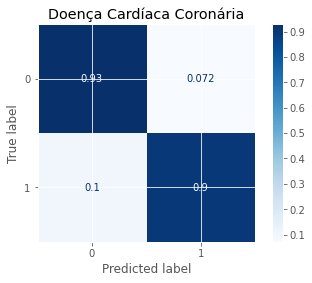

In [11]:
np.set_printoptions(precision=2)

print("\n\n O Melhor Algoritmo: ",est_pred.selected_model_,'\n\n Com Acurácia de: ',metrics.accuracy_score(test.y, est_pred.predict(test.X)),'\n\n')

disp = ConfusionMatrixDisplay.from_estimator(
    est_pred,
    test.X,
    test.y,
    display_labels=est_pred.classes_,
    cmap=plt.cm.Blues,
    normalize="true",
)

disp.ax_.set_title("Doença Cardíaca Coronária")

plt.show()

### Agora Validações mais detalhadas utilizando a biblioteca ADS

In [12]:
dt_model = ADSModel.from_estimator(est_pred)
single_evaluator = ADSEvaluator(test, models=[dt_model])

[2022-05-10 20:27:07,967] [automl.preprocessing] transform: After feature engineering and transformations. Updated shape : (719, 15)
[2022-05-10 20:27:08,025] [automl.preprocessing] transform: After feature engineering and transformations. Updated shape : (719, 15)


In [13]:
single_evaluator.metrics

HTML(value='<style type="text/css">\n#T_1d08a_row0_col0, #T_1d08a_row1_col0, #T_1d08a_row2_col0, #T_1d08a_row3…

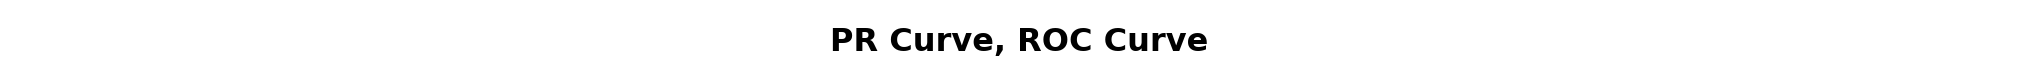

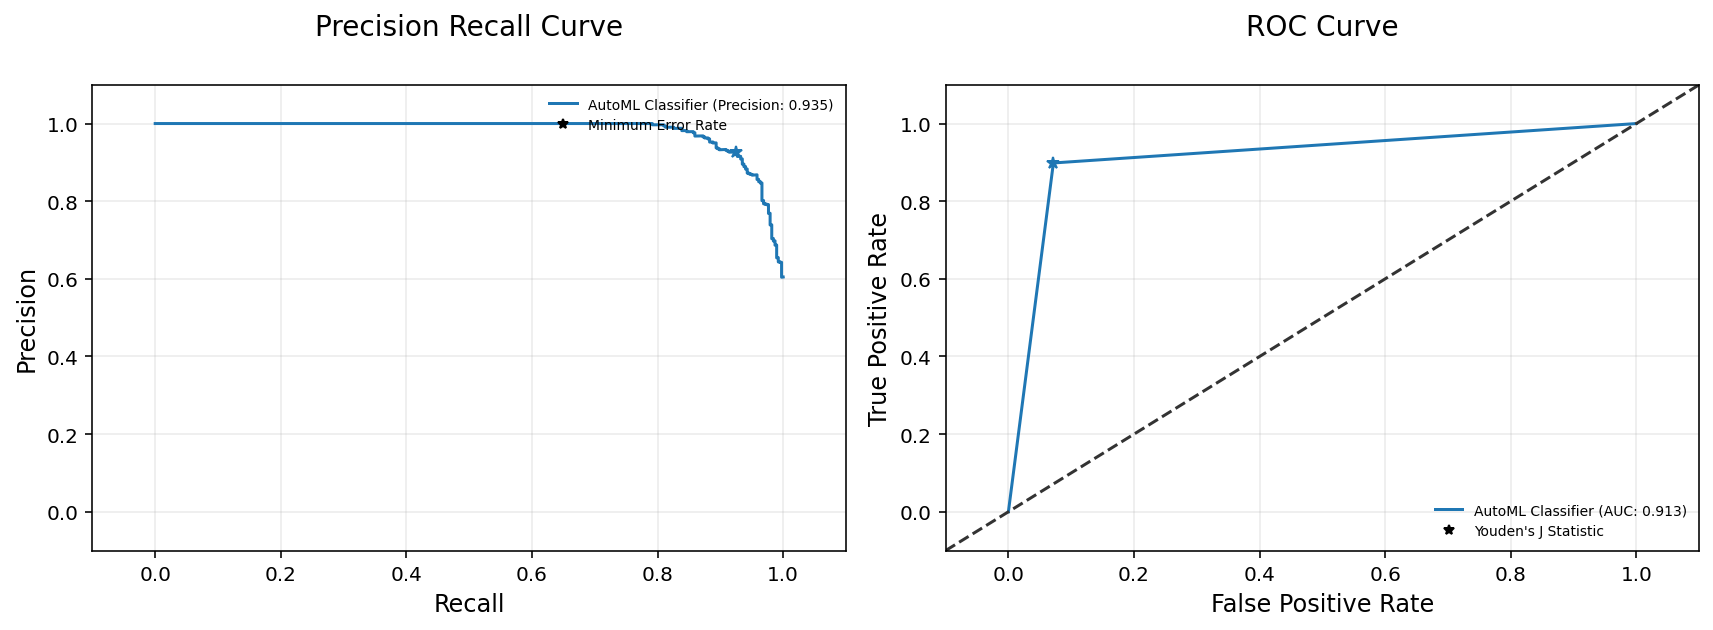

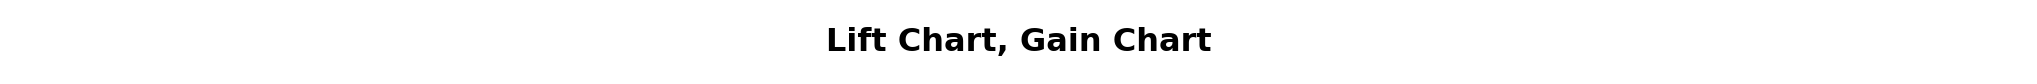

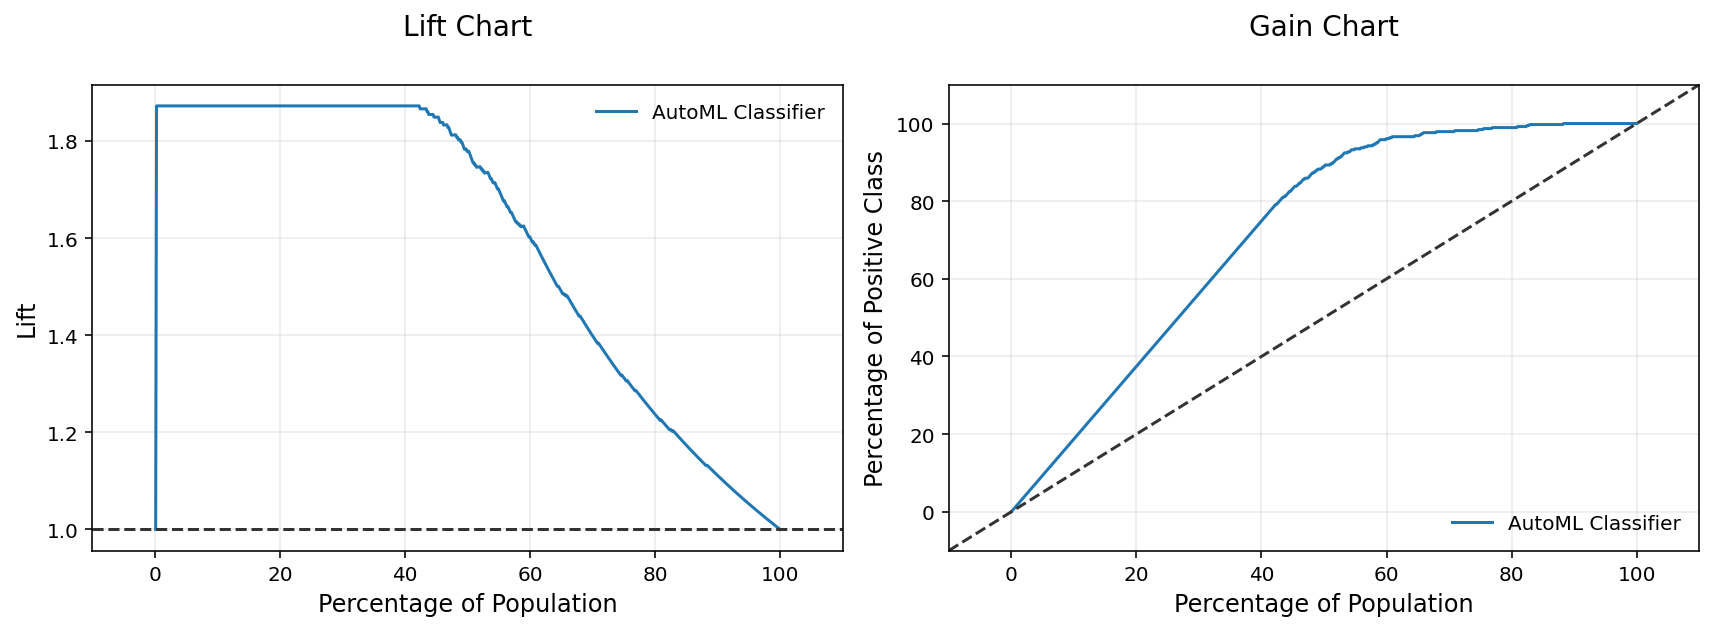

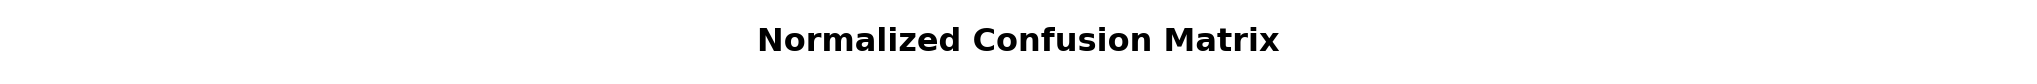

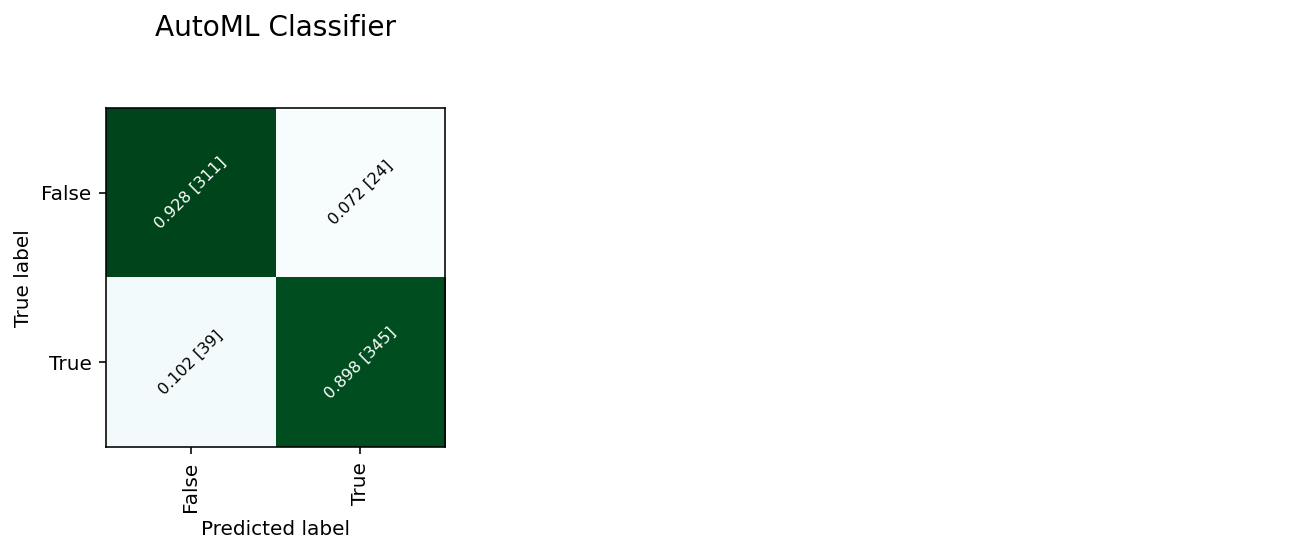

In [14]:
single_evaluator.show_in_notebook()

In [ ]:
explainer = ADSExplainer(test, dt_model, training_data=train)
mlx.initjs()

In [ ]:
pi_exp = PermutationImportance()
pi_exp.show_in_notebook()

In [ ]:
target_names = [False, True]
pi_exp.fit(dt_model,train.X,y=train.y,target_names=target_names) 
explanation = pi_exp.compute(test.X, test.y)

### E aqui obtêm-se a importância de cada variável utilizada para o modelo gerado

In [ ]:
explanation.show_in_notebook(mode='box_plot')

#### Gráficos para avaliar como foi o processo automático de Amostragem Adaptativa, Seleção de Features e Ajuste de Hiperparâmetros

In [ ]:
adap_sample(est_pred)

In [ ]:
feat_selec(est_pred)

In [ ]:
hyper_tuning(est_pred)

### Processo de MLOps

#### Salvando o modelo no Model Catalog

In [15]:
compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID']
project_id = os.environ['PROJECT_OCID']

In [16]:
dt_model = ADSModel.from_estimator(est_pred)
artifact_path = '/home/datascience/modelo_1'
artifact_model = dt_model.prepare(artifact_path, force_overwrite=True, 
                                     data_sample=test, data_science_env=True)

loop1:   0%|          | 0/5 [00:00<?, ?it/s]

[2022-05-10 20:27:42,157] [automl.interface] Execution engine (local) has already been initialized. Reinitializing!
INFO:xengine:All work stopped
INFO:xengine:All work stopped
[2022-05-10 20:27:42,235] [automl.xengine] Local ProcessPool execution (n_jobs=1)
[2022-05-10 20:27:42,236] [automl.xengine] Using Single Node XEngine with n_jobs: 1
[2022-05-10 20:27:42,244] [automl.xengine] Max timeout per task is set to 1500
[2022-05-10 20:27:42,251] [automl.xengine] local xengine initialization: <multiprocessing.pool.Pool object at 0x7f48bce38650>
Start loading model.pkl from model directory /home/datascience/modelo_1 ...
Model is successfully loaded.
[2022-05-10 20:27:42,333] [automl.interface] Execution engine (local) has already been initialized. Reinitializing!
INFO:xengine:All work stopped
INFO:xengine:All work stopped
[2022-05-10 20:27:42,454] [automl.xengine] Local ProcessPool execution (n_jobs=1)
[2022-05-10 20:27:42,455] [automl.xengine] Using Single Node XEngine with n_jobs: 1
[2022

In [21]:
mc_model = artifact_model.save(project_id=project_id, compartment_id=compartment_id, 
                               display_name="AutoML Binary Classifier - CHD", 
                               description="AutoML Binary Classifier with LGBMClassifier", 
                               ignore_pending_changes=True)

loop1:   0%|          | 0/5 [00:00<?, ?it/s]

artifact:/tmp/saved_model_cc146376-d759-468c-be3a-36a92fe14cf0.zip


In [22]:
model_id = mc_model.id
print(f"Model OCID: {model_id}")

Model OCID: ocid1.datasciencemodel.oc1.sa-saopaulo-1.amaaaaaanf7stlyadewan4hkdgxle7zr5ppzz2hmhtxyay6zjaftg2j7cxda


#### Configuração da instância que receberá o modelo em produção

In [23]:
model_configuration_details_object = ModelConfigurationDetails(model_id=model_id,
                                                               instance_configuration=InstanceConfiguration(instance_shape_name='VM.Standard2.1'),
                                                               scaling_policy=FixedSizeScalingPolicy(instance_count=1),
                                                               bandwidth_mbps=20)

In [24]:
single_model_config = SingleModelDeploymentConfigurationDetails(deployment_type='SINGLE_MODEL',
                                                                model_configuration_details=model_configuration_details_object)

#### Criando ambiente de Logs para acompanhamento do modelo em produção

In [25]:
log_group_name = "ModelDeployment"
access_log_name = "Access_Log"
predict_log_name = "Predict_Log"

log_group = OCILogGroup(display_name=log_group_name).create()
log_group_ocid = log_group.id
print(f"Log group OCID: {log_group_ocid}")

access_log = log_group.create_log(access_log_name)
access_log_ocid = access_log.id
print(f"Access log OCID: {access_log_ocid}")

# Create a predict log in the log group
predict_log = log_group.create_log(predict_log_name)
predict_log_ocid = predict_log.id
print(f"Predict log OCID: {predict_log_ocid}")

logs_configuration_details_object = CategoryLogDetails(access=LogDetails(log_group_id=log_group_ocid,
                                                                         log_id=access_log_ocid),
                                                       predict=LogDetails(log_group_id=log_group_ocid,
                                                                          log_id=predict_log_ocid))

Log group OCID: ocid1.loggroup.oc1.sa-saopaulo-1.amaaaaaanf7stlyao2ghsr3nzqdm3odt4pkuwqwmbvovj4iea4idjaawwgga
Access log OCID: ocid1.log.oc1.sa-saopaulo-1.amaaaaaanf7stlyanh7wiwldyjphslj7njpueglu6kaqjfgmyxu5wrhornfa
Predict log OCID: ocid1.log.oc1.sa-saopaulo-1.amaaaaaanf7stlya235ioryhmm3wcoozaxibbtbygxnlxcxcxxvnyoo75j5a


#### Configurando os detalhes do modelo antes de colocá-lo em produção

In [26]:
model_deploy_configuration = CreateModelDeploymentDetails(display_name='Predicao de CHD',
                                                          description='Modelo de predicao de coronary heart disease',
                                                          project_id=os.environ['PROJECT_OCID'],
                                                          compartment_id=os.environ['NB_SESSION_COMPARTMENT_OCID'],
                                                          model_deployment_configuration_details=single_model_config,
                                                          category_log_details=logs_configuration_details_object
                                                         )

### Autenticando e aplicando as configurações para colocar o modelo em produção

In [27]:
auth = oci.auth.signers.get_resource_principals_signer()
data_science = DataScienceClient({}, signer=auth)
data_science_composite = DataScienceClientCompositeOperations(data_science)

### Este processo levará de 13 a 15 minutos, pois é aqui onde as instâncias são provisionadas e configuradas

In [28]:
%%time

deployer = data_science_composite.create_model_deployment_and_wait_for_state(
    model_deploy_configuration, 
    wait_for_states=["SUCCEEDED", "FAILED"]
)

CPU times: user 2.51 s, sys: 326 ms, total: 2.83 s
Wall time: 13min 6s


#### Obtendo a identificação do modelo em produção

In [29]:
deployer = ModelDeployer()

for active in deployer.list_deployments(status="ACTIVE", compartment_id=compartment_id):
    deployment_id = active.properties.id
    print(active.properties.id)

ocid1.datasciencemodeldeployment.oc1.sa-saopaulo-1.amaaaaaanf7stlyap2shre4lhusqjasadvrgyqrzzfo4ugiod2ezotxiwgua


### Preparando os acessos para enviar requisições para gerar previsões com o modelo criado e em produção

In [30]:
deployment = deployer.get_model_deployment(model_deployment_id=deployment_id)
print(f"deployment OCID: {deployment.model_deployment_id}\n" +
      f"existing deployment OCID: {deployment.model_deployment_id}")

deployment OCID: ocid1.datasciencemodeldeployment.oc1.sa-saopaulo-1.amaaaaaanf7stlyap2shre4lhusqjasadvrgyqrzzfo4ugiod2ezotxiwgua
existing deployment OCID: ocid1.datasciencemodeldeployment.oc1.sa-saopaulo-1.amaaaaaanf7stlyap2shre4lhusqjasadvrgyqrzzfo4ugiod2ezotxiwgua


### Pegando um conjunto de informações para gerar previsão de CHD através do modelo em produção

In [31]:
pred = df_CHD.to_pandas_dataframe()
pred = pred.drop(columns = ["TenYearCHD"])

In [32]:
deployment.predict(pred[513:514].to_json())

{'prediction': [0]}

In [33]:
deployment.predict('{"male":{"0":1},"age":{"0":42},"education":{"0":4.0},"currentSmoker":{"0":0},"cigsPerDay":{"0":0.0},"BPMeds":{"0":1.0},"prevalentStroke":{"0":0},"prevalentHyp":{"0":1},"diabetes":{"0":0},"totChol":{"0":160.0},"sysBP":{"0":130.0},"diaBP":{"0":90.0},"BMI":{"0":25.00},"heartRate":{"0":80.0},"glucose":{"0":80.0}}')

{'prediction': [0]}

### Quem souber as próprias informações e quiser saber se tem a chance de sofrer CHD nos próximos 10 anos, basta alterar as informações abaixo:
### ***Atenção: Alterar os valores que estão entre {"0":XX.X}, representados pelos "X"!!!

In [ ]:
deployment.predict('{"male":{"0":X},"age":{"0":XX},"education":{"0":X.0},"currentSmoker":{"0":X},"cigsPerDay":{"0":X.0},"BPMeds":{"0":X.0},"prevalentStroke":{"0":X},"prevalentHyp":{"0":X},"diabetes":{"0":X},"totChol":{"0":XXX.0},"sysBP":{"0":XXX.0},"diaBP":{"0":XXX.0},"BMI":{"0":XX.00},"heartRate":{"0":XX.0},"glucose":{"0":XX.0}}')

In [ ]:
from time import sleep
for i in range (0, 20, 1):
    deployment.predict(test.X[i:i+1].to_json())
    sleep(25-i)

## Source

The dataset is publically available on the Kaggle website, and it is from an ongoing cardiovascular study on residents of the town of Framingham, Massachusetts. The classification goal is to predict whether the patient has 10-year risk of future coronary heart disease (CHD).The dataset provides the patients’ information. It includes over 4,000 records and 15 attributes.
Variables
Each attribute is a potential risk factor. There are both demographic, behavioral and medical risk factors.

https://www.tuasaude.com/doenca-coronariana/

### Demographic:

• Sex: male or female(Nominal)

• Age: Age of the patient;(Continuous - Although the recorded ages have been truncated to whole numbers, the concept of age is continuous)

### Behavioral

• Current Smoker: whether or not the patient is a current smoker (Nominal)

• Cigs Per Day: the number of cigarettes that the person smoked on average in one day.(can be considered continuous as one can have any number of cigarettes, even half a cigarette.)

### Medical(history)

• BP Meds: whether or not the patient was on blood pressure medication (Nominal)

• Prevalent Stroke: whether or not the patient had previously had a stroke (Nominal)

• Prevalent Hyp: whether or not the patient was hypertensive (Nominal)

• Diabetes: whether or not the patient had diabetes (Nominal)

### Medical(current)

• Tot Chol: total cholesterol level (Continuous)

• Sys BP: systolic blood pressure (Continuous)

• Dia BP: diastolic blood pressure (Continuous)

• BMI: Body Mass Index (Continuous)

• Heart Rate: heart rate (Continuous - In medical research, variables such as heart rate though in fact discrete, yet are considered continuous because of large number of possible values.)

• Glucose: glucose level (Continuous)

### Predict variable (desired target)

• 10 year risk of coronary heart disease CHD (binary: “1”, means “Yes”, “0” means “No”)

### CREDIT TO:
Kaggle for the dataset: https://www.kaggle.com/dileep070/heart-disease-prediction-using-logistic-regression